# N-Springed Pendulum
In this notebook we'll be solving the equations of motion for an n-springed pendulum which is impossible to do by hand. Based on [lukepolson's work](https://github.com/lukepolson/youtube_channel/blob/main/Python%20Metaphysics%20Series/vid7.ipynb).

## Background
Diagram of a double springed pendulum:

<img src="double_springed_pendulum.svg" alt="diagram" width="400"/>

The variables involved are:
- Time $t$
- Gravitational acceleration $g$
- Mass of pendulum bobs $m$
- Spring constants $k$
- Natural lengths of springs (when no massed is attached) $l$
- Stretched lengths of the springs $r_i$
- Angles that the spring makes with the horizontal plane $\theta_i$

The position of bob $j$, in cartesian coordinates are related to the length $r_j$ and angle $\theta_j$ with the following formulas:

$$\displaystyle x_j= \sum_{i=1}^j (l+r_i)cos\theta_i $$
$$\displaystyle y_j= \sum_{i=1}^j -(l+r_i)sin\theta_i $$

To simplify calculations, we will make $l$ the base unit such that our equations can become:
$$\displaystyle x_j= \sum_{i=1}^j (1+r_i)cos\theta_i $$
$$\displaystyle y_j= \sum_{i=1}^j -(1+r_i)sin\theta_i $$


## Import libraries

In [1]:
import numpy as np
import sympy as smp
import scipy.integrate
import matplotlib.pyplot as plt
import matplotlib.animation

## Define variables

### Set $n$
The number of springs/bobs

In [7]:
n = 2

### Define time, gravitational constant, masses, spring constants, angles and stretched lengths

In [10]:
# Define time and gravitational constant
t, g, m, k = smp.symbols('t g m k')

# Define lists of theta's and r's that are functions of time
the = smp.symbols(rf'\theta_:{n}', cls=smp.Function)
the = [the_n(t) for the_n in the]
r = smp.symbols(f'r_:{n}', cls=smp.Function)
r = [r_n(t) for r_n in r]

### Check that the symbols and functions have been correctly defined

In [11]:
r[0]

r_0(t)

### Define the first and second derivatives of $\theta$ and $r$

In [12]:
the_d = [smp.diff(the_n, t) for the_n in the]
the_dd = [smp.diff(the_d_n, t) for the_d_n in the_d]

r_d = [smp.diff(r_n, t) for r_n in r]
r_dd = [smp.diff(r_d_n, t) for r_d_n in r_d]

### Verify definitions

In [13]:
the_dd[0]

Derivative(\theta_0(t), (t, 2))

In [14]:
r_dd[0]

Derivative(r_0(t), (t, 2))

### Define cartesian coordinates of each bob $(x_j,y_j)$ 
where, $x_j$ and $y_j$ are functions of $\theta_{0 \leq i \leq j}$ and $r_{0 \leq i \leq j}$


In [15]:
x = list(smp.symbols(f'x_:{n}', cls=smp.Function))
x = [x_j(*the[:j+1], *r[:j+1]) for j, x_j in enumerate(x)]
y = list(smp.symbols(f'y_:{n}', cls=smp.Function))
y = [y_j(*the[:j+1], *r[:j+1]) for j, y_j in enumerate(y)]

In [16]:
y[0]

y_0(\theta_0(t), r_0(t))

### Define the equations of the functions
$$\displaystyle x_j= \sum_{i=0}^j (1+r_i)cos\theta_i $$
$$\displaystyle y_j= \sum_{i=0}^j -(1+r_i)sin\theta_i $$

In [17]:
for j in range(n):
    x[j] = sum([(1+r[i])*smp.cos(the[i]) for i in range(j+1)])
    x[j] = smp.simplify(x[j])
    y[j] = sum([-(1+r[i])*smp.sin(the[i]) for i in range(j+1)])
    y[j] = smp.simplify(y[j])

### Verify equations

In [18]:
y[0]

(-r_0(t) - 1)*sin(\theta_0(t))

In [19]:
y[1]

-(r_0(t) + 1)*sin(\theta_0(t)) - (r_1(t) + 1)*sin(\theta_1(t))

### Define the Lagrangian $L=T-V$ where,


Total kinetic energy: 
$$
T= \displaystyle \sum_{i=0}^{n-1} \frac{1}{2}m(\dot{x}^2_i+\dot{y}^2_i)
$$

Total potential energy: 
$$
V = \displaystyle \sum_{i=0}^{n-1} (
        \overbrace{m g y_i}^
            {\substack{\text{gravitational} \\ \text{potential} \\ \text{energy}}} +
        \overbrace{\frac{1}{2}k r_i^2}^
            {\substack{\text{elastic} \\ \text{potential} \\ \text{energy}}}
    )
$$

In [20]:
T = sum([1/2 * m * (smp.diff(x[i], t)**2 + smp.diff(y[i], t)**2) for i in range(n)])
V = sum([m * g * y[i] + 1/2 * k * r[i]**2 for i in range(n)])
L = T - V

### Verify

In [21]:
T

0.5*m*(((-r_0(t) - 1)*cos(\theta_0(t))*Derivative(\theta_0(t), t) - sin(\theta_0(t))*Derivative(r_0(t), t))**2 + (-(r_0(t) + 1)*sin(\theta_0(t))*Derivative(\theta_0(t), t) + cos(\theta_0(t))*Derivative(r_0(t), t))**2) + 0.5*m*(((-r_0(t) - 1)*cos(\theta_0(t))*Derivative(\theta_0(t), t) + (-r_1(t) - 1)*cos(\theta_1(t))*Derivative(\theta_1(t), t) - sin(\theta_0(t))*Derivative(r_0(t), t) - sin(\theta_1(t))*Derivative(r_1(t), t))**2 + (-(r_0(t) + 1)*sin(\theta_0(t))*Derivative(\theta_0(t), t) - (r_1(t) + 1)*sin(\theta_1(t))*Derivative(\theta_1(t), t) + cos(\theta_0(t))*Derivative(r_0(t), t) + cos(\theta_1(t))*Derivative(r_1(t), t))**2)

In [22]:
V

g*m*(-(r_0(t) + 1)*sin(\theta_0(t)) - (r_1(t) + 1)*sin(\theta_1(t))) + g*m*(-r_0(t) - 1)*sin(\theta_0(t)) + 0.5*k*r_0(t)**2 + 0.5*k*r_1(t)**2

## Compute Lagrange's Equations

$$\frac{\partial L}{\partial z}-\frac{d}{dt}\frac{\partial L}{\partial \dot{z}}=0$$

where $z$ is each of $\{\theta_0, \dots, \theta_{n-1}, r_0, \dots, r_{n-1}\}$

In [26]:
args = [*the, *r]
args_d = [*the_d, *r_d]

LE = [(smp.diff(L, arg) - smp.diff(smp.diff(L, args_d[i]), t)).simplify() for i, arg in enumerate(args)]

In [27]:

print(f'Number of Lagrange equations = {len(LE)}')
LE[0]

Number of Lagrange equations = 4


m*(2.0*g*r_0(t)*cos(\theta_0(t)) + 2.0*g*cos(\theta_0(t)) - 2.0*r_0(t)**2*Derivative(\theta_0(t), (t, 2)) - 1.0*r_0(t)*r_1(t)*sin(\theta_0(t) - \theta_1(t))*Derivative(\theta_1(t), t)**2 - 1.0*r_0(t)*r_1(t)*cos(\theta_0(t) - \theta_1(t))*Derivative(\theta_1(t), (t, 2)) - 1.0*r_0(t)*sin(\theta_0(t) - \theta_1(t))*Derivative(\theta_1(t), t)**2 + 1.0*r_0(t)*sin(\theta_0(t) - \theta_1(t))*Derivative(r_1(t), (t, 2)) - 2.0*r_0(t)*cos(\theta_0(t) - \theta_1(t))*Derivative(\theta_1(t), t)*Derivative(r_1(t), t) - 1.0*r_0(t)*cos(\theta_0(t) - \theta_1(t))*Derivative(\theta_1(t), (t, 2)) - 4.0*r_0(t)*Derivative(\theta_0(t), t)*Derivative(r_0(t), t) - 4.0*r_0(t)*Derivative(\theta_0(t), (t, 2)) - 1.0*r_1(t)*sin(\theta_0(t) - \theta_1(t))*Derivative(\theta_1(t), t)**2 - 1.0*r_1(t)*cos(\theta_0(t) - \theta_1(t))*Derivative(\theta_1(t), (t, 2)) - 1.0*sin(\theta_0(t) - \theta_1(t))*Derivative(\theta_1(t), t)**2 + 1.0*sin(\theta_0(t) - \theta_1(t))*Derivative(r_1(t), (t, 2)) - 2.0*cos(\theta_0(t) - \the

## Solve Lagrange Equations for $\frac{d^2 z}{dt^2}$
using an ODE solver,
where $z$ is each of the free variables $\{\theta_0, \dots, \theta_{n-1}, r_0, \dots, r_{n-1}\}$.

This will give us two equations for each free variable,
$$\displaystyle \frac{dz}{dt} = v_z$$
$$\displaystyle \frac{dv_z}{dt} = \text{what we solved for}$$

This turns our system of second order ordinary differential equations into systems of first order differential equations.

In [28]:
args_dd = (*the_dd, *r_dd)
sols = smp.solve(LE, args_dd, simplify=False, rational=False)

In [30]:
sols[args_dd[0]]

-0.00390625*g*m*sin(\theta_0(t) - \theta_1(t))*sin(\theta_1(t))/(0.00390625*m*r_0(t)*sin(\theta_0(t) - \theta_1(t))**2 + 0.00390625*m*r_0(t)*cos(\theta_0(t) - \theta_1(t))**2 - 0.0078125*m*r_0(t) + 0.00390625*m*sin(\theta_0(t) - \theta_1(t))**2 + 0.00390625*m*cos(\theta_0(t) - \theta_1(t))**2 - 0.0078125*m) + 0.00390625*g*m*cos(\theta_0(t) - \theta_1(t))*cos(\theta_1(t))/(0.00390625*m*r_0(t)*sin(\theta_0(t) - \theta_1(t))**2 + 0.00390625*m*r_0(t)*cos(\theta_0(t) - \theta_1(t))**2 - 0.0078125*m*r_0(t) + 0.00390625*m*sin(\theta_0(t) - \theta_1(t))**2 + 0.00390625*m*cos(\theta_0(t) - \theta_1(t))**2 - 0.0078125*m) - 0.0078125*g*m*cos(\theta_0(t))/(0.00390625*m*r_0(t)*sin(\theta_0(t) - \theta_1(t))**2 + 0.00390625*m*r_0(t)*cos(\theta_0(t) - \theta_1(t))**2 - 0.0078125*m*r_0(t) + 0.00390625*m*sin(\theta_0(t) - \theta_1(t))**2 + 0.00390625*m*cos(\theta_0(t) - \theta_1(t))**2 - 0.0078125*m) + 0.00390625*k*r_1(t)*sin(\theta_0(t) - \theta_1(t))/(0.00390625*m*r_0(t)*sin(\theta_0(t) - \theta_1(t)

## Create numerical functions for $v_z$ and $\frac{dv_z}{dt}$
where $z$ is each of the free variables $\{\theta_0, \dots, \theta_{n-1}, r_0, \dots, r_{n-1}\}$.

In [31]:
v_f = [smp.lambdify(args=args_d_i, expr=args_d_i) for args_d_i in args_d]
v_d_f = [smp.lambdify(args=[m, k, g, *args, *args_d], expr=sols[args_dd_i]) for args_dd_i in args_dd]

## Define our system of ODEs
$$S=(v_0, \dots, v_{2n-1}, \frac{dv_0}{dt}, \dots, \frac{dv_{2n-1}}{dt})$$

In [43]:
def dSdt(S, t):
    return[
        *[v_f_i(S[i + 2*n]) for i, v_f_i in enumerate(v_f)], # The input for the1_f is the1_d, so need to skip 2n to get to the derivatives of v
        *[v_d_f_i(m, k, g, *S) for v_d_f_i in v_d_f]
    ]

## Solve ODEs
to calculate how the free variables evolve over time for a particular set of fixed variables $g, m, k$ and initial conditions $\displaystyle S_{t=0}=(v_{0_{t=0}}, \dots, v_{2n-1_{t=0}}, \frac{dv_{0_{t=0}}}{dt}, \dots, \frac{dv_{2n-1_{t=0}}}{dt})$

In [4]:
t = np.linspace(0, 20, 500)
g = 9.81
m = 1
k = 10
s0=[np.pi/2, (3/2)*np.pi/2, 0, 0, 0, 0, 5, 5]

In [ ]:
ans = scipy.integrate.odeint(dSdt, y0=s0, t=t)

## Plot

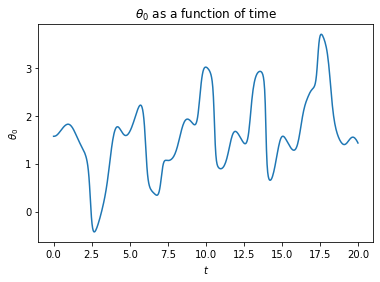

In [64]:
plt.plot(t, ans.T[0])
plt.ylabel(r'$\theta_0$')
plt.xlabel(r'$t$')
plt.title(r'$\theta_0$ as a function of time');

### Create numerical functions to get cartesian coordinates

In [46]:
x_f = [smp.lambdify(args=[*the[:j+1], *r[:j+1]], expr=x_j) for j, x_j in enumerate(x)]
y_f = [smp.lambdify(args=[*the[:j+1], *r[:j+1]], expr=y_j) for j, y_j in enumerate(y)]

#### Sanity check for numerical functions for $(x_0,y_0)$

with values
- $l_0=1$
- $r_0=1$
- $0 \leq \theta_1 \leq \pi$

Should see a semicircle with radius 2 which is the path traced out by the first bob

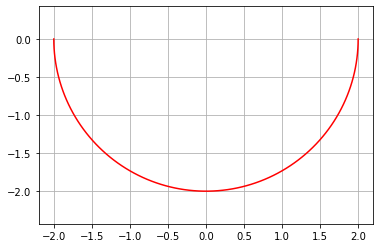

In [73]:
temp_theta = np.linspace(0,np.pi,100)
plt.plot(x_f[0](temp_theta,1), y_f[0](temp_theta,1), '-r')
plt.axis('equal')
plt.grid(True)

### Get x and y values as functions of time

In [65]:
the_vals = ans.T[0:n]
r_vals = ans.T[n:2*n]
x_vals = [x_f_i(*the_vals[:i+1], *r_vals[:i+1]) for i, x_f_i in enumerate(x_f)]
y_vals = [y_f_i(*the_vals[:i+1], *r_vals[:i+1]) for i, y_f_i in enumerate(y_f)]


### Animate

In [8]:
def stringify_number(x) -> str:
    return str(round(x,2)).replace('.','dot')
def stringify_list_of_numbers(t: list) -> str:
    return '_'.join([stringify_number(x) for x in t])

gif_file_name = f'{n}_springed_pendulum_m_{stringify_number(m)}_k_{stringify_number(k)}_g_{stringify_number(g)}_s0_{stringify_list_of_numbers(s0)}.gif'
file_path = f'animations_fixed_lmk/{gif_file_name}'
file_path

'animations_fixed_lmk/2_springed_pendulum_m_1_k_10_g_9dot81_s0_1dot57_2dot36_0_0_0_0_5_5.gif'

In [77]:
def flatten(t):
    return [item for sublist in t for item in sublist]

In [136]:
%%capture
fps = 25
y_vals_flat = flatten(y_vals)
y_min = min(y_vals_flat)-1
y_max = max(y_vals_flat)+1
x_vals_abs = [abs(val) for val in flatten(x_vals)]
x_lim = max(x_vals_abs)+1

def animate(i):
    ln1.set_data([0, *[x_vals_j[i] for x_vals_j in x_vals]], [0, *[y_vals_j[i] for y_vals_j in y_vals]])
    time.set_text(f't={round(i/fps)}s')
    
fig, ax = plt.subplots(1,1, figsize=(8,8))
ax.grid()
plt.title(f'{n}-Springed Pendulum')
plt.ylabel(r'$y$')
plt.xlabel(r'$x$')
ln1, = plt.plot([], [], 'ro--', lw=3, markersize=8)
ax.set_ylim(y_min, y_max)
ax.set_xlim(-x_lim,x_lim)
bbox = dict(boxstyle='square,pad=0.3', fc='white')
annotation_text = '\n'.join([f'$m={m}$', f'$g={g}$', f'$k={k}$\n', 'initial cond:', *[f'${args[i]}={round(s0[i],2)}$' for i in range(2*n)], 'where $t=0$'])
ax.text(0.05, 0.95, annotation_text,transform=ax.transAxes, bbox=bbox, va='top', ha='left')
time = ax.text(0.95, 0.95, '',transform=ax.transAxes, va='top', ha='right')

ani = matplotlib.animation.FuncAnimation(fig, animate, frames=500, interval=25)
ani.save(file_path,writer='pillow',fps=fps, savefig_kwargs={'facecolor':'white'})

In [9]:
from IPython.display import Markdown
Markdown(f'![animation]({file_path})')

![animation](animations_fixed_lmk/2_springed_pendulum_m_1_k_10_g_9dot81_s0_1dot57_2dot36_0_0_0_0_5_5.gif)